In [30]:
# Import tensorflow core

import tensorflow as tf

# Import Keras Model and Layer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

# Import Keras Utility

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Import library for utility

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np
import os

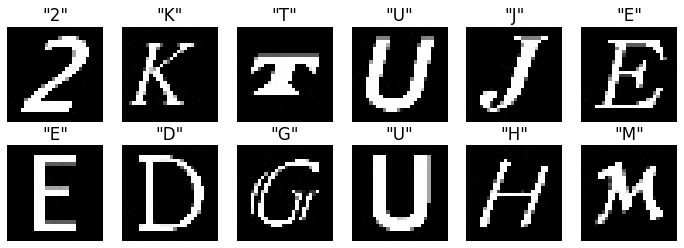

In [11]:
# Visualize Dataset

dataset_paths = glob.glob("./data/source/**/*.jpg")

ncols = 6
nrows = 2
figure = plt.figure(figsize=(12, 4))
plt.rcParams.update({"font.size": 14})
grid = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=figure)

np.random.seed(0)
rand = np.random.randint(0, len(dataset_paths), size=(ncols * nrows))

for i in range(ncols * nrows):
    figure.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

In [12]:
# Label Encoding

X = []
labels = []

for image_path in dataset_paths:
    label = image_path.split(os.path.sep)[-2]
    image = load_img(image_path, target_size=(80, 80))
    image = img_to_array(image)

    X.append(image)
    labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Found {:d} images with {:d} classes".format(len(X), len(set(labels))))

# One-hot encoding
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

np.save('license_character_classes.npy', lb.classes_)

[INFO] Found 37623 images with 36 classes


In [36]:
(train_x, test_x, train_y, test_y) = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [37]:
def construct_model(output_shape):
    base_model = MobileNetV2(
        weights="imagenet", include_top=False, input_tensor=Input(shape=(80, 80, 3)))

    for layer in base_model.layers:
        layer.trainable = True

    base_model_output = base_model.output
    fc_model = AveragePooling2D(pool_size=(3, 3))(base_model_output)
    fc_model = Flatten(name="flatten")(fc_model)
    fc_model = Dense(128, activation="relu")(fc_model)
    fc_model = Dropout(0.5)(fc_model)
    fc_model = Dense(output_shape, activation="softmax")(fc_model)

    return Model(inputs=base_model.input, outputs=fc_model)

In [ ]:
"""
Model 01
LR = 1e-3, EPOCH = 15, Testing data = 10%

Model 02
LR = 1e-4, EPOCH = 30, Testing data = 10%
"""

In [38]:
# Construct Model
LR = 1e-3
EPOCHS = 15

classes = y.shape[1]

model = construct_model(output_shape=classes)

optimizer = Adam(learning_rate=LR, decay=LR/EPOCHS)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer, metrics=["accuracy"])

In [39]:
augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [40]:
BATCH_SIZE = 64

STEP_PER_EPOCH = len(train_x) // BATCH_SIZE
VALIDATION_STEPS = len(test_x) // BATCH_SIZE

my_checkpointer = [EarlyStopping(monitor='val_loss', patience=5, verbose=0)]

model_history = model.fit(augmentation.flow(train_x, train_y, batch_size=BATCH_SIZE),
          steps_per_epoch=STEP_PER_EPOCH,
          validation_data=(test_x, test_y),
          validation_steps=VALIDATION_STEPS,
          epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/15
529/529 [==============================] - 229s 421ms/step - loss: 0.9853 - accuracy: 0.7393 - val_loss: 8.7997 - val_accuracy: 0.0904
Epoch 2/15
529/529 [==============================] - 214s 403ms/step - loss: 0.4448 - accuracy: 0.8841 - val_loss: 3.4813 - val_accuracy: 0.4417
Epoch 3/15
529/529 [==============================] - 223s 421ms/step - loss: 0.3413 - accuracy: 0.9071 - val_loss: 0.9690 - val_accuracy: 0.8212
Epoch 4/15
529/529 [==============================] - 242s 457ms/step - loss: 0.3059 - accuracy: 0.9168 - val_loss: 1.0130 - val_accuracy: 0.7853
Epoch 5/15
529/529 [==============================] - 286s 540ms/step - loss: 0.2710 - accuracy: 0.9244 - val_loss: 0.5700 - val_accuracy: 0.8743
Epoch 6/15
529/529 [==============================] - 248s 468ms/step - loss: 0.2493 - accuracy: 0.9306 - val_loss: 0.5355 - val_accuracy: 0.8921
Epoch 7/15
529/529 [==============================] - 178s 337ms/step - loss: 0.2379 - accuracy: 0.9332 - val_loss: 0.5133 -

In [41]:
model.save("./src/models/plate_char_classifier_02.h5")

d:\Github Repo\monopol\env\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


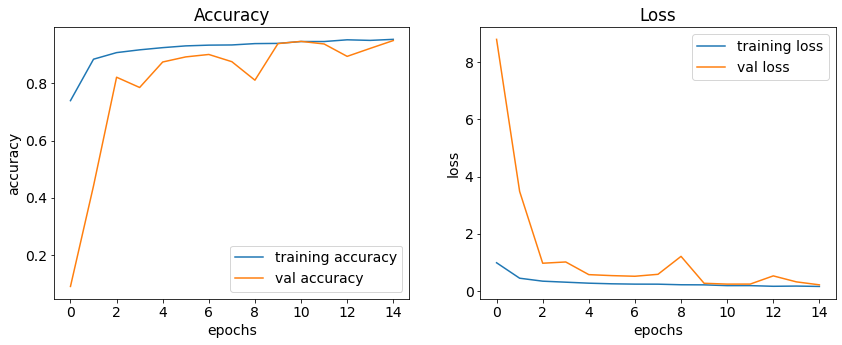

In [42]:
figure = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2, nrows=1, figure=figure)
figure.add_subplot(grid[0])
plt.plot(model_history.history['accuracy'], label='training accuracy')
plt.plot(model_history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

figure.add_subplot(grid[1])
plt.plot(model_history.history['loss'], label='training loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [43]:
# save model architectur as json file
model_json = model.to_json()
with open("./src/models/MobileNetV2_plate_character_recognizer.json", "w") as json_file:
  json_file.write(model_json)